# Encoding Word Embeddings with Hand Picked Features

URLS

# Constants

Here, you can alter the dataset, maximum number of samples to use, etc.

In [ ]:
DMOZ, ILP, PHISHING = 'dmoz', 'ilp', 'phishing'

DATASET = DMOZ  # one of the above datsets
MAX_NUM_SAMPLES = 1_000_000

TEST_PROP = 0.2
VAL_PROP = 0.2
EPOCHS = 8

SEED = 42

## Setup


You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [ ]:
command = f'git clone --depth 1 https://github.com/shmulvad/nlp-project.git'
!{command}

%cd nlp-project/src

Cloning into 'nlp-project'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 60 (delta 6), reused 35 (delta 3), pack-reused 0
Unpacking objects: 100% (60/60), done.
/content/nlp-project/src


In [ ]:
!pip install gdown

# DMOZ, ILP and original phishing dataset - datasets.pkl
!gdown --id 1WV1JSevCnaWY0-mqQMmtOEFSC3Y_Qdg_

print('\n')
!ls

Downloading...
From: https://drive.google.com/uc?id=1WV1JSevCnaWY0-mqQMmtOEFSC3Y_Qdg_
To: /content/nlp-project/src/datasets.pkl
99.4MB [00:00, 139MB/s]


 baselines		    read_data.py
'Colab Notebooks'	    requirements.txt
 create_fasttext_embed.py   run_feat_experiments.ipynb
 data			    self_trained_embeddings.py
 datasets.pkl		    tests
 demo.ipynb		    url_tokenizer.py
 feat-experiments.pickle    util.py
 featurizer.py		    word_embed
 pickle_data.py


In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text
!pip install -q tf-models-official
!pip install -r requirements.txt

     |████████████████████████████████| 3.4MB 7.9MB/s 
     |████████████████████████████████| 1.1MB 9.2MB/s 
     |████████████████████████████████| 1.2MB 33.5MB/s 
     |████████████████████████████████| 706kB 50.1MB/s 
     |████████████████████████████████| 102kB 14.2MB/s 
     |████████████████████████████████| 174kB 51.6MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 358kB 50.3MB/s 
     |████████████████████████████████| 645kB 54.0MB/s 
     |████████████████████████████████| 37.6MB 81kB/s 
     |████████████████████████████████| 542kB 7.5MB/s 
     |████████████████████████████████| 23.9MB 138kB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-cp37-none-any.whl size=541554 sha256=825f350e5a0485b22ec26c6318ceefd1209046ac002eab0053a5de05d8c4009e
  Stored in directory: /root/.cache/pip/wheels/22/46/06/9b6d10ed02c85e93c3bb33ac50e2d368b2586248f192a2e22a
Successfully built wordninja
  Found existing installation: gensim 3.

In [ ]:
import os
import shutil
import random
import pickle

from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from pprint import pprint
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import gensim
from gensim.models.keyedvectors import FastTextKeyedVectors

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
tf.get_logger().setLevel('ERROR')
np.random.seed(SEED)

from read_data import read_all_datasets
from url_tokenizer import url_tokenizer, flatten_url_data
from featurizer import UrlFeaturizer, GLOVE, CONCEPTNET, SAMPLE

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [ ]:
with open('datasets.pkl', 'rb') as f:
  datasets = pickle.load(f)

assert DATASET in datasets, \
  f'You tried to load {DATASET} but only {list(datasets.keys())} available.'

dataset = datasets[DATASET]
dataset

,idx,url,label
946066,946067,http://www.thepipe.info,Recreation
1322925,1322926,http://childlifeline.org,Society
1538731,1538732,http://www.fchd.info/fleett.htm,Sports
529412,529413,http://www.ee.umn.edu/users/kieffer/,Computers
639891,639892,http://www.ftprush.com,Computers
...,...,...,...
1467240,1467241,http://www.usatoday.com/sports/college/mensbas...,Sports
483946,483947,http://www.appraisal.co.nz/,Business
900141,900142,http://www.wild-about-hunting.com/,Recreation
320948,320949,http://www.searchlites.com/,Business


In [ ]:
# Download respectively model and ngrams
if DATASET == DMOZ:
  !gdown --id 1V8_EWQTF_JhgEVbXIvAiHViTHyIO9CBS
  !gdown --id 15EirC5KybMrG33RvYUXIfnBM2GWSBdh5
elif DATASET == ILP:
  !gdown --id 1_QafULaXKmq0H0fwY3dkR-WOKwsyUkHS
  !gdown --id 1kn4EbllSLdAX-8Ca5db6_BewLugCAWp5
else:  # Phishing
  !gdown --id 1JEsUG4eGqbIItBH468xph-AsS3iQ5Fif
  !gdown --id 10p0XPRsuTsXblQNNlUricEmd8if0B2P6

fast_text_embedding = FastTextKeyedVectors.load(f'embed-{DATASET}.model')

Downloading...
From: https://drive.google.com/uc?id=1V8_EWQTF_JhgEVbXIvAiHViTHyIO9CBS
To: /content/nlp-project/src/embed-dmoz.model
23.0MB [00:00, 55.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=15EirC5KybMrG33RvYUXIfnBM2GWSBdh5
To: /content/nlp-project/src/embed-dmoz.model.vectors_ngrams.npy
800MB [00:08, 97.1MB/s]


In [2]:
import re
import pandas as pd

from tensorflow.keras import backend as K
from keras.layers import Layer
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Bidirectional, TimeDistributed, Conv1D, ZeroPadding1D, GRU, Concatenate
from tensorflow.keras.layers import Lambda, Input, Dropout, Masking, BatchNormalization, Activation, Attention, SpatialDropout1D, Reshape
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from tqdm import tqdm

## Different approaches to Encode

Here we simply flatten the word embeddings for each URL and append the handpicked featrues

Thus, the (31,100) embeddings are flattened to (3100,) vector.
Further appending the handpicked features makes the vector shape: (3120,)


#### Enocoder 2 --> Piecewise

In [ ]:
def valid_url(url):
  match = url_regex.match(url.lower())
  if match:
    return True
  else:
    return False

url_regex = re.compile(r'''
        (https?):\/\/                                   # http s
        ([-a-zA-Z0-9@:%._\+~#=]+\.[a-zA-Z0-9()]{1,12})  # domains
        \b
        ([-a-zA-Z0-9()@:%_\+;.~#&//=]*)                 # path
        \??
        ([-a-zA-Z0-9()@:%_\+;.~#&//=?]*)                # args
    ''', re.DOTALL | re.VERBOSE)

In [ ]:
def prepare_df(dataset):
    df = dataset.copy()
    df.reset_index(drop = True, inplace = True)
    df['valid'] = df.url.apply(lambda x:valid_url(x))
    df = df[df['valid']==True]
    df.drop(['valid'],axis=1,inplace=True)
    urls = np.array(df.url)
    le = LabelEncoder()
    labels = le.fit_transform(df.label)  
    return le,urls,labels

def GenerateFeatureVector_Enc2(urls, UF):
    raw_features = feat.featurize(urls)

    embeddings = list()
    hand_picked = list()
    for feature in raw_features:
        embeddings.append(feature[1])
        hand_picked.append(feature[0])

    embeddings = np.array(embeddings)
    hand_picked = np.array(hand_picked)

    sub_domain = embeddings[:,:5,:]
    main_domain = embeddings[:,5:10,:]
    domain_end_vec = embeddings[:,10,:].reshape(-1,1,100)
    path = embeddings[:,11:21,:]
    arg = embeddings[:,21:,:]


    return [sub_domain,main_domain,domain_end_vec,path,arg,hand_picked]

## Model

##Fast Text

In [ ]:
sampled_dataset = dataset.sample(n=25000)

In [ ]:
_,urls,labels = prepare_df(sampled_dataset)

In [ ]:
X_train_mid,X_test_mid,Y_train,Y_test=train_test_split(urls,labels,test_size=0.2)

In [ ]:
feat = UrlFeaturizer(embedding=fast_text_embedding)

Creating the average vector of all the word vectors...
Created FastText UrlFeaturizer in 0.0 s


In [ ]:
X_train = GenerateFeatureVector_Enc2(X_train_mid,feat)
X_test = GenerateFeatureVector_Enc2(X_test_mid,feat)

ohe = OneHotEncoder(sparse=False)
Y_test = Y_test.reshape(-1,1)
Y_train = Y_train.reshape(-1,1)
Y_train = ohe.fit_transform(Y_train)
Y_test_check = Y_test
Y_test = ohe.transform(Y_test)

### Testing Features by Deep Model

In [3]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [6]:
dtype = 'float64'
dropout=0.2

input_data_1 = Input(name='the_input_1', shape=(5,100), dtype=dtype)
input_data_2 = Input(name='the_input_2', shape=(5,100), dtype=dtype)
input_data_3 = Input(name='the_input_3', shape=(1,100), dtype=dtype)
input_data_4 = Input(name='the_input_4', shape=(10,100), dtype=dtype)
input_data_5 = Input(name='the_input_5', shape=(10,100), dtype=dtype)
input_data_6 = Input(name='the_input_6', shape=(20,), dtype=dtype)

lstm1 = LSTM(50)(input_data_1)
lstm2 = LSTM(50)(input_data_2)
lstm3 = LSTM(50)(input_data_3)
lstm4 = LSTM(50)(input_data_4)
lstm5 = LSTM(50)(input_data_5)

concatted = Concatenate()([lstm1,lstm2,lstm3,lstm4,lstm5])
new_input = Reshape((250,1))(concatted)

att_in = Bidirectional(LSTM(32,return_sequences=True,dropout=0.3,recurrent_dropout=0.2))(new_input)
att_out = Bidirectional(LSTM(32,return_sequences=False,dropout=0.3,recurrent_dropout=0.2))(att_in)

concatted = Concatenate()([att_out,input_data_6])
# att_out=attention()(att_in)
# 1 fully connected layer DNN ReLu with default 20% dropout
x = Dense(units=64, activation='tanh', name='fc')(concatted)
x = Dropout(dropout, name='dropout_2')(x)

# Output layer with softmax
y_pred = Dense(units=15, activation='softmax', name='softmax')(x) 

K.clear_session()
model = Model(inputs=[input_data_1,input_data_2,input_data_3,input_data_4,input_data_5,input_data_6], outputs=y_pred)  
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input_1 (InputLayer)        [(None, 5, 100)]     0                                            
__________________________________________________________________________________________________
the_input_2 (InputLayer)        [(None, 5, 100)]     0                                            
__________________________________________________________________________________________________
the_input_3 (InputLayer)        [(None, 1, 100)]     0                                            
__________________________________________________________________________________________________
the_input_4 (InputLayer)        [(None, 10, 100)]    0                                            
______________________________________________________________________________________________

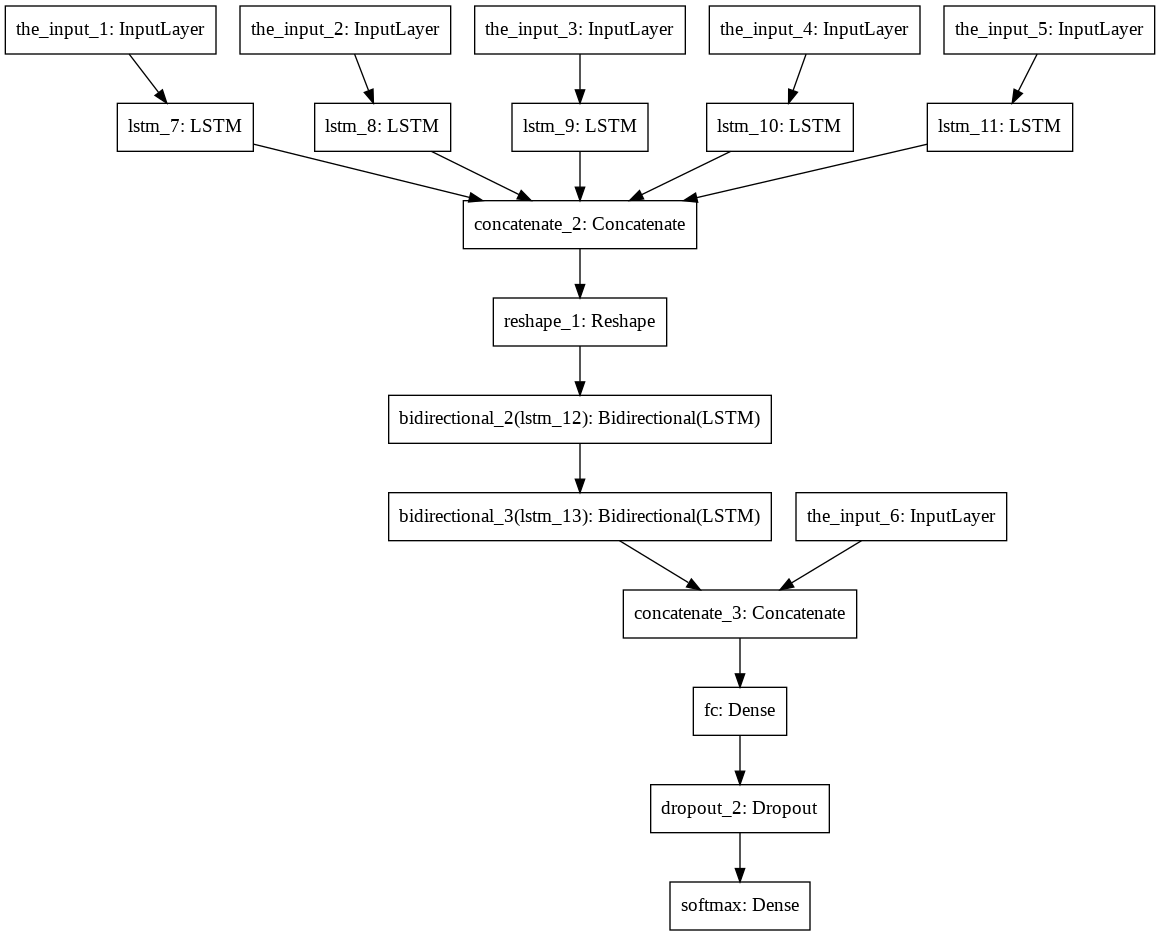

In [7]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='model.png')

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

sgd = SGD()
adam = Adam()

checkpoint = ModelCheckpoint('checkpoint', monitor='val_loss', verbose=0,
                                 save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss",
                              mode="min",
                              patience=7)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.7,
                                           patience=2,
                                           verbose=1, mode='min', min_delta=0.0001, cooldown=3,
                                           min_lr=1e-9)  # epsilon here is a good starting value


# , clipnorm=1.0

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
history = model.fit(X_train, Y_train,
                    batch_size=128, epochs=50,
                    validation_data=(X_test, Y_test),
                    callbacks=[checkpoint, early, reduceLROnPlat])

Epoch 1/50
157/157 [==============================] - 509s 3s/step - loss: 2.7139 - accuracy: 0.1500 - val_loss: 2.3275 - val_accuracy: 0.2486


Epoch 2/50
157/157 [==============================] - 508s 3s/step - loss: 2.3929 - accuracy: 0.2301 - val_loss: 2.2510 - val_accuracy: 0.2878


Epoch 3/50
157/157 [==============================] - 512s 3s/step - loss: 2.2809 - accuracy: 0.2889 - val_loss: 2.1855 - val_accuracy: 0.3064


Epoch 4/50
157/157 [==============================] - 503s 3s/step - loss: 2.2149 - accuracy: 0.3040 - val_loss: 2.1922 - val_accuracy: 0.3098
Epoch 5/50
157/157 [==============================] - 494s 3s/step - loss: 2.1730 - accuracy: 0.3160 - val_loss: 2.1407 - val_accuracy: 0.3190


Epoch 6/50
157/157 [==============================] - 503s 3s/step - loss: 2.1231 - accuracy: 0.3251 - val_loss: 2.1251 - val_accuracy: 0.3252


Epoch 7/50
157/157 [==============================] - 504s 3s/step - loss: 2.0993 - accuracy: 0.3369 - val_loss: 2.0830 - val_accuracy: 0.3322


Epoch 8/50
157/157 [==============================] - 502s 3s/step - loss: 2.0348 - accuracy: 0.3546 - val_loss: 2.0799 - val_accuracy: 0.3342


Epoch 9/50
157/157 [==============================] - 503s 3s/step - loss: 2.0228 - accuracy: 0.3578 - val_loss: 2.0587 - val_accuracy: 0.3432


Epoch 10/50
157/157 [==============================] - 499s 3s/step - loss: 1.9738 - accuracy: 0.3710 - val_loss: 2.0345 - val_accuracy: 0.3534


Epoch 11/50
157/157 [==============================] - 506s 3s/step - loss: 1.9413 - accuracy: 0.3833 - val_loss: 2.0304 - val_accuracy: 0.3530


Epoch 12/50
157/157 [==============================] - 506s 3s/step - loss: 1.9203 - accuracy: 0.3887 - val_loss: 2.0421 - val_accuracy: 0.3482
Epoch 13/50
157/157 [==============================] - 499s 3s/step - loss: 1.8901 - accuracy: 0.3999 - val_loss: 2.0458 - val_accuracy: 0.3588

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
Epoch 14/50
157/157 [==============================] - 498s 3s/step - loss: 1.8453 - accuracy: 0.4223 - val_loss: 2.0247 - val_accuracy: 0.3618


Epoch 15/50
157/157 [==============================] - 497s 3s/step - loss: 1.8089 - accuracy: 0.4265 - val_loss: 2.0435 - val_accuracy: 0.3602
Epoch 16/50
157/157 [==============================] - 498s 3s/step - loss: 1.7900 - accuracy: 0.4403 - val_loss: 2.0425 - val_accuracy: 0.3650
Epoch 17/50
157/157 [==============================] - 495s 3s/step - loss: 1.7520 - accuracy: 0.4458 - val_loss: 2.0469 - val_accuracy: 0.3588

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.
Epoch 18/50
157/157 [==============================] - 499s 3s/step - loss: 1.7395 - accuracy: 0.4480 - val_loss: 2.0564 - val_accuracy: 0.3634
Epoch 19/50
157/157 [==============================] - 499s 3s/step - loss: 1.7264 - accuracy: 0.4531 - val_loss: 2.0501 - val_accuracy: 0.3678
Epoch 20/50
157/157 [==============================] - 498s 3s/step - loss: 1.6910 - accuracy: 0.4698 - val_loss: 2.0595 - val_accuracy: 0.3606
Epoch 21/50
157/157 [==============================] - 

## Evaluating Model


In [ ]:
Y_JGJ_pred = model.predict(X_test)
pred = ohe.inverse_transform(Y_JGJ_pred)
print(classification_report(Y_test_check,pred))

              precision    recall  f1-score   support

           0       0.35      0.29      0.32       101
           1       0.35      0.50      0.41       800
           2       0.41      0.64      0.50       738
           3       0.35      0.15      0.21       380
           4       0.41      0.36      0.38       169
           5       0.34      0.16      0.21       197
           6       0.00      0.00      0.00        79
           7       0.32      0.04      0.08       160
           8       0.00      0.00      0.00        30
           9       0.18      0.08      0.11       330
          10       0.41      0.20      0.27       200
          11       0.52      0.27      0.35       367
          12       0.27      0.26      0.26       326
          13       0.38      0.52      0.44       789
          14       0.34      0.39      0.36       334

    accuracy                           0.37      5000
   macro avg       0.31      0.26      0.26      5000
weighted avg       0.35   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(f1_score(Y_test_check,pred,average = 'weighted'))

0.3400789336668583
